In [30]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
import sklearn.model_selection

In [31]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

In [32]:
boston = load_boston()


# First we package up the input data and the target variable (the median value) as pandas dataframes. This
# will make saving the data to a file a little easier later on.

X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)



In [33]:
X_DATA = X_bos_pd[["CRIM","AGE"]].head(30)
Y_DATA = Y_bos_pd.head(50)

X_DATA.insert(0,"target",Y_DATA)

In [34]:
data = X_DATA

data

,target,CRIM,AGE
0,24.0,0.00632,65.2
1,21.6,0.02731,78.9
2,34.7,0.02729,61.1
3,33.4,0.03237,45.8
4,36.2,0.06905,54.2
5,28.7,0.02985,58.7
6,22.9,0.08829,66.6
7,27.1,0.14455,96.1
8,16.5,0.21124,100.0
9,18.9,0.17004,85.9


In [35]:
# We split the dataset into 2/3 training and 1/3 testing sets.
train_data, test_data = sklearn.model_selection.train_test_split(data, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
train_data, val_data = sklearn.model_selection.train_test_split(train_data, test_size=0.33)

In [36]:
print("train_data : ", len(train_data))
print("test_data : ", len(test_data))
print("val_data : ", len(val_data))

val_data

train_data :  13
test_data :  10
val_data :  7


,target,CRIM,AGE
23,14.5,0.98843,100.0
17,17.5,0.78420,81.7
28,18.4,0.77299,94.4
22,15.2,1.23247,91.7
10,15.0,0.22489,94.3
15,19.9,0.62739,56.5
25,13.9,0.84054,85.7


In [37]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# X_DATA = X_bos_pd[["CRIM","AGE"]].head(30)

X_test = test_data[["CRIM","AGE"]]
Y_test = test_data[["target"]]
    
# test_data.to_csv(os.path.join(data_dir, 'test_3.csv'), header=False, index=False)
X_test.to_csv(os.path.join(data_dir, 'test_3.csv'), header=False, index=False)
train_data.to_csv(os.path.join(data_dir, 'train_3.csv'), header=False, index=False)
val_data.to_csv(os.path.join(data_dir, 'val_3.csv'), header=False, index=False)


# X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
X_test

,CRIM,AGE
4,0.06905,54.2
19,0.72580,69.5
12,0.09378,39.0
0,0.00632,65.2
18,0.80271,36.6
7,0.14455,96.1
26,0.67191,90.3
6,0.08829,66.6
1,0.02731,78.9
24,0.75026,94.1


In [38]:
prefix = 'boston-xgboost-HL-tutorial-3'

test_location = session.upload_data(os.path.join(data_dir, 'test_3.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'val_3.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train_3.csv'), key_prefix=prefix)

In [39]:
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [40]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

In [41]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-09 09:31:03 Starting - Starting the training job...
2020-09-09 09:31:05 Starting - Launching requested ML instances......
2020-09-09 09:32:28 Starting - Preparing the instances for training......
2020-09-09 09:33:26 Downloading - Downloading input data...
2020-09-09 09:33:58 Training - Downloading the training image..
2020-09-09 09:34:29 Uploading - Uploading generated training model
2020-09-09 09:34:29 Completed - Training job completed
Arguments: train
[2020-09-09:09:34:18:INFO] Running standalone xgboost training.
[2020-09-09:09:34:18:INFO] File size need to be processed in the node: 0.0mb. Available memory size in the node: 8485.79mb
[2020-09-09:09:34:18:INFO] Determined delimiter of CSV input is ','
[09:34:18] S3DistributionType set as FullyReplicated
[09:34:18] 13x2 matrix with 26 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-09-09:09:34:18:INFO] Determined delimiter of CSV input is ','
[09:34:18] S3DistributionType set as FullyR

In [42]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer.wait()

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


............................2020-09-09T09:39:19.227:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Arguments: serve
[2020-09-09 09:39:19 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-09-09 09:39:19 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-09-09 09:39:19 +0000] [1] [INFO] Using worker: gevent
[2020-09-09 09:39:19 +0000] [36] [INFO] Booting worker with pid: 36
[2020-09-09 09:39:19 +0000] [37] [INFO] Booting worker with pid: 37
[2020-09-09 09:39:19 +0000] [38] [INFO] Booting worker with pid: 38
[2020-09-09 09:39:19 +0000] [39] [INFO] Booting worker with pid: 39
Arguments: serve
[2020-09-09 09:39:19 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-09-09 09:39:19 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-09-09 09:39:19 +0000] [1] [INFO] Using worker: gevent
[2020-09-09 09:39:19 +0000] [36] [INFO] Booting worker with pid: 36
[2020-09-09 09:39:19 +0000] [37] [INFO] Booting worker with pid: 37
[2020-09-09 09

In [43]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-2-360760555806/xgboost-2020-09-09-09-34-46-157/test_3.csv.out to ../data/boston/test_3.csv.out


Text(0.5, 1.0, 'Median Price vs Predicted Price')

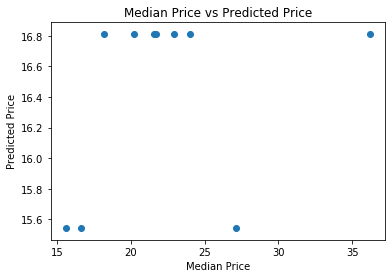

In [45]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test_3.csv.out'), header=None)
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

In [47]:
Y_pred

,0
0,16.810143
1,16.810143
2,16.810143
3,16.810143
4,16.810143
5,15.544428
6,15.544428
7,16.810143
8,16.810143
9,15.544428


In [48]:
df = Y_test.rename(columns={'newName1': 'test'}).reset_index(drop=True)

df["predict"] = Y_pred

df

,target,predict
0,36.2,16.810143
1,18.2,16.810143
2,21.7,16.810143
3,24.0,16.810143
4,20.2,16.810143
5,27.1,15.544428
6,16.6,15.544428
7,22.9,16.810143
8,21.6,16.810143
9,15.6,15.544428


In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score

rms = sqrt(mean_squared_error(Y_test, Y_pred))
mae = MAE(Y_test, Y_pred)
r_score = r2_score(Y_test, Y_pred)


In [52]:


print("rms : " , rms)
print("mae  :", mae)
print("r_score : ", r_score)

rms :  8.122018434306606
mae  : 5.97957187652
r_score :  -1.0690458975568822
